# Scrapes
We compare methods of "scraping" high-level variables, like invariant mass $M_{jj}$ of the two leading jets, leading jet $p_T$, and $\Delta\eta$ of the leading jets:
- Lab vs. Higgs frame
- Selecting by number of jets
- Particular variables for the case of 3 jets

Note: this is a messy notebook for me to do my research in, so not everything will be well explained.

In [84]:
import root_numpy
import ROOT

import numpy as np
import matplotlib.pyplot as plt

import os

from collections import defaultdict
from root_numpy import root2array

from datareader import scrape_folder, scrape_regular, scrape_hacky, scrape_selective_gen, scrape_maxpt, scrape_maxdeta, scrape_higgs
from datareader import histograms, plot_histograms, draw_ROC

In [2]:
# import importlib
# importlib.reload(datareader.scrape_regular)

In [3]:
# just to define the branches
filename = '../data/vbfroot/data-CxAOD-0.root'
branch_names = root_numpy.list_branches(filename, 'Nominal')
branch = {name:number for number,name in enumerate(branch_names)}

In [4]:
%%time

vbf_regular = scrape_folder('../data/vbfroot/', branch, scrape_regular)
ggf_regular = scrape_folder('../data/ggfroot/', branch, scrape_regular)

vbf_maxdeta = scrape_folder('../data/vbfroot/', branch, scrape_maxdeta)
ggf_maxdeta = scrape_folder('../data/ggfroot/', branch, scrape_maxdeta)

reading file ../data/vbfroot/data-CxAOD-0.root
reading file ../data/vbfroot/data-CxAOD-1.root
reading file ../data/ggfroot/data-CxAOD-0.root
reading file ../data/ggfroot/data-CxAOD-1.root
reading file ../data/vbfroot/data-CxAOD-0.root
reading file ../data/vbfroot/data-CxAOD-1.root
reading file ../data/ggfroot/data-CxAOD-0.root
reading file ../data/ggfroot/data-CxAOD-1.root
CPU times: user 27 s, sys: 620 ms, total: 27.7 s
Wall time: 27.6 s


In [5]:
%%time

vbf_maxpt = scrape_folder('../data/vbfroot/', branch, scrape_maxpt)
ggf_maxpt = scrape_folder('../data/ggfroot/', branch, scrape_maxpt)
# vbf_hacky = scrape_folder('../data/vbfroot/', branch, scrape_hacky)
# ggf_hacky = scrape_folder('../data/ggfroot/', branch, scrape_hacky)

reading file ../data/vbfroot/data-CxAOD-0.root
reading file ../data/vbfroot/data-CxAOD-1.root
reading file ../data/ggfroot/data-CxAOD-0.root
reading file ../data/ggfroot/data-CxAOD-1.root
CPU times: user 14.1 s, sys: 236 ms, total: 14.3 s
Wall time: 14.3 s


In [85]:
%%time

vbf_higgs = scrape_folder('../data/vbfroot/', branch, scrape_higgs)
ggf_higgs = scrape_folder('../data/ggfroot/', branch, scrape_higgs)

reading file ../data/vbfroot/data-CxAOD-0.root
reading file ../data/vbfroot/data-CxAOD-1.root
reading file ../data/ggfroot/data-CxAOD-0.root
reading file ../data/ggfroot/data-CxAOD-1.root
CPU times: user 17.1 s, sys: 372 ms, total: 17.4 s
Wall time: 17.4 s


In [86]:
print('higgs', len(vbf_higgs['deta']))

higgs 53604


In [6]:
# %%time

# vbf_selective = scrape_folder('../data/vbfroot/', branch, scrape_selective_gen(0))
# ggf_selective = scrape_folder('../data/ggfroot/', branch, scrape_selective_gen(0))

In [7]:
print('regular', len(vbf_regular['deta']))
print('maxpt', len(vbf_maxpt['deta']))
print('maxdeta', len(vbf_maxpt['deta']))
#print('hacky', len(vbf_hacky['deta']))
#print('selective', len(vbf_selective['deta']))

regular 53604
maxpt 53604
maxdeta 53604


In [8]:
## Now we're going to filter data based on njets

In [9]:
def filter_data(old_data, condition_key, condition, renormalize=False):
    # Filters scraped data in a form to match a new condition
    # For example:
    #   vbf_maxpt2 = filter_data(vbf_maxpt, 'njets', lambda x: x == 2)
    
    new_data = defaultdict(list)

    for key in old_data.keys():        
        for i, condition_val in enumerate(old_data[condition_key]):
            if condition(condition_val):
                new_data[key].append(old_data[key][i])
    
    # renormalize weights    
    if renormalize:
        new_data['weight'] = np.array(new_data['weight'])
        new_data['weight'] /= np.sum(new_data['weight'])
    
    return new_data

In [10]:
vbf_maxpt2 = filter_data(vbf_maxpt, 'njets', lambda x: x == 2, renormalize=True)
ggf_maxpt2 = filter_data(ggf_maxpt, 'njets', lambda x: x == 2, renormalize=True)

vbf_maxpt3 = filter_data(vbf_maxpt, 'njets', lambda x: x == 3, renormalize=True)
ggf_maxpt3 = filter_data(ggf_maxpt, 'njets', lambda x: x == 3, renormalize=True)

vbf_maxpt4 = filter_data(vbf_maxpt, 'njets', lambda x: x == 4, renormalize=True)
ggf_maxpt4 = filter_data(ggf_maxpt, 'njets', lambda x: x == 4, renormalize=True)

vbf_maxpt5p = filter_data(vbf_maxpt, 'njets', lambda x: x >= 5, renormalize=True)
ggf_maxpt5p = filter_data(ggf_maxpt, 'njets', lambda x: x >= 5, renormalize=True)

In [82]:
def njets_plots(varname, maxval, nbins=100, saving=False):
    print('Plots for: ' + varname)

    h_maxpt, h_maxpt_bg, bin_edges = histograms(varname, (0,maxval), vbf_maxpt, ggf_maxpt, nbins=nbins)
    h2_maxpt, h2_maxpt_bg, bin_edges = histograms(varname, (0, maxval), vbf_maxpt2, ggf_maxpt2, nbins=nbins)
    h3_maxpt, h3_maxpt_bg, bin_edges = histograms(varname, (0, maxval), vbf_maxpt3, ggf_maxpt3, nbins=nbins)
    h4_maxpt, h4_maxpt_bg, bin_edges = histograms(varname, (0, maxval), vbf_maxpt4, ggf_maxpt4, nbins=nbins)
    h5p_maxpt, h5p_maxpt_bg, bin_edges = histograms(varname, (0, maxval), vbf_maxpt5p, ggf_maxpt5p, nbins=nbins)

    draw_ROC(h_maxpt, h_maxpt_bg, label='All', color='black',show=False)
    draw_ROC(h2_maxpt, h2_maxpt_bg, label='njets = 2', show=False)
    draw_ROC(h3_maxpt, h3_maxpt_bg, label='njets = 3', show=False)
    draw_ROC(h4_maxpt, h4_maxpt_bg, label='njets = 4', show=False)
    draw_ROC(h5p_maxpt, h5p_maxpt_bg, label=r'njets $\geq$ 5', title='ROC for %s'%varname,
             savefig=('../imgs/jan18_%s_jetroc.pdf'%varname) if saving else None)

    plot_histograms(h2_maxpt, h2_maxpt_bg, bin_edges, xlabel=varname+' (njets = 2)',
                    savefig=('../imgs/jan18_%s_jet2.pdf'%varname) if saving else None)
    plot_histograms(h3_maxpt, h3_maxpt_bg, bin_edges, xlabel=varname+' (njets = 3)',
                    savefig=('../imgs/jan18_%s_jet3.pdf'%varname) if saving else None)
    plot_histograms(h4_maxpt, h4_maxpt_bg, bin_edges, xlabel=varname+' (njets = 4)',
                    savefig=('../imgs/jan18_%s_jet4.pdf'%varname) if saving else None)
    plot_histograms(h5p_maxpt, h5p_maxpt_bg, bin_edges, xlabel=varname+r' (njets $\geq$ 5)',
                    savefig=('../imgs/jan18_%s_jet5p.pdf'%varname) if saving else None)

Plots for: deta


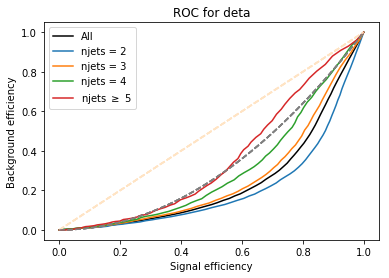

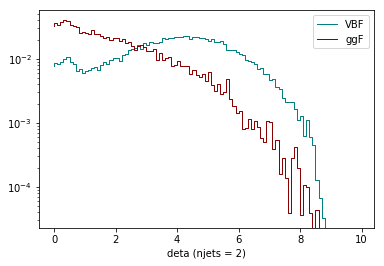

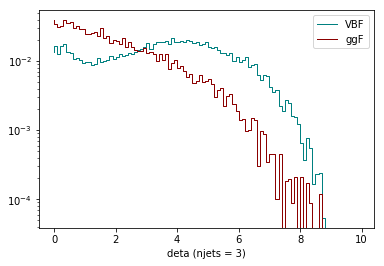

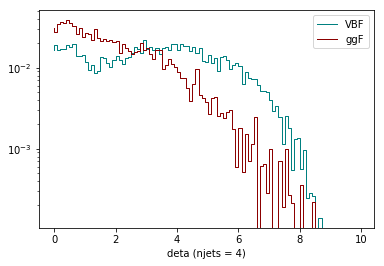

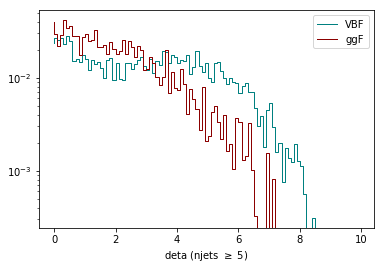

In [71]:
njets_plots('deta', 10, saving=False)

Plots for: mjj


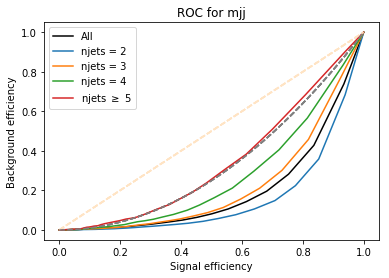

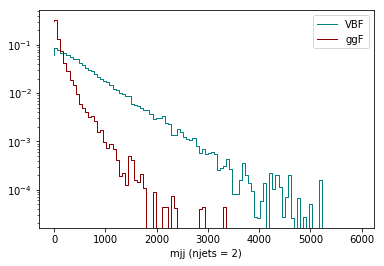

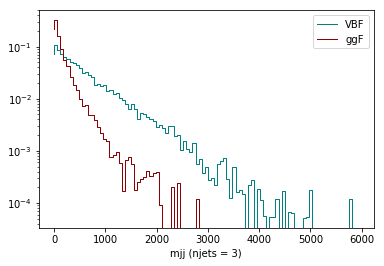

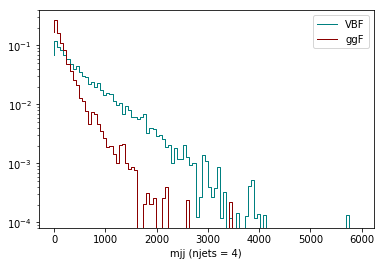

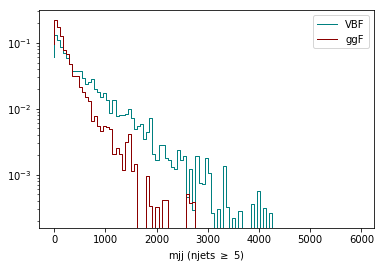

In [76]:
njets_plots('mjj', 6000, nbins=100, saving=False)

Plots for: leadpt


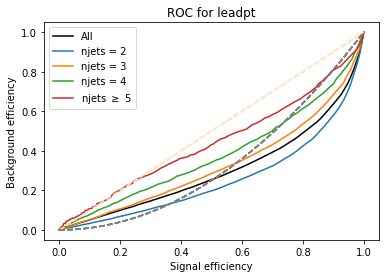

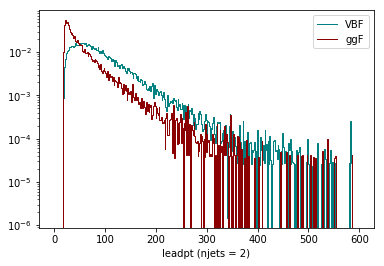

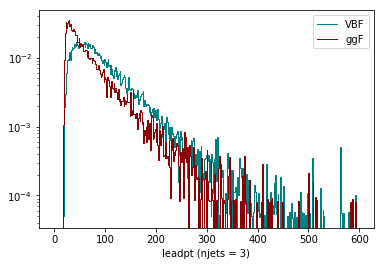

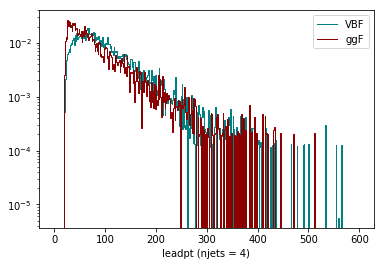

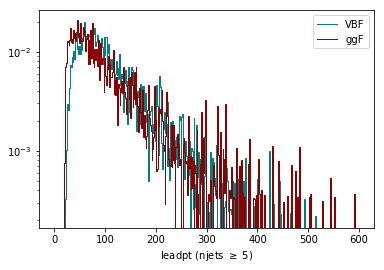

In [73]:
njets_plots('leadpt', 600, nbins=400, saving=False)

Plots for: subleadpt


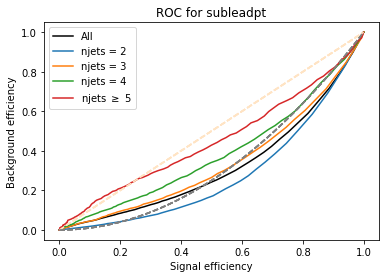

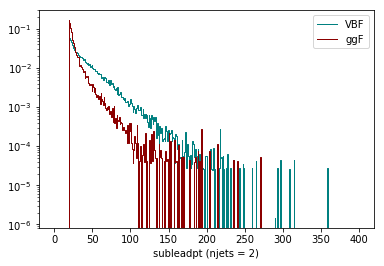

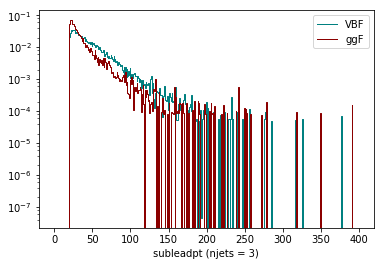

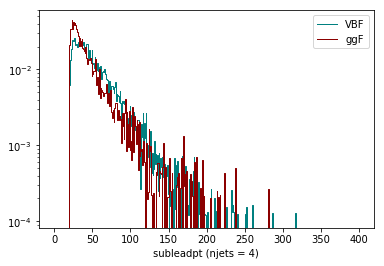

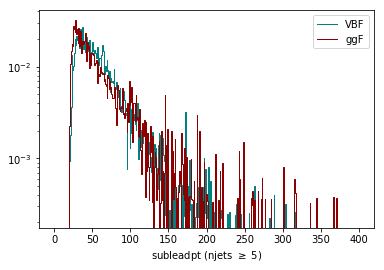

In [74]:
njets_plots('subleadpt', 400, nbins=400, saving=False)

Plots for: subsubleadpt


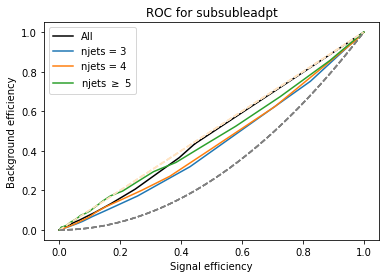

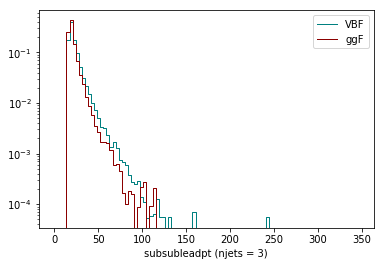

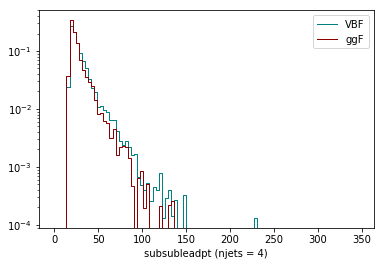

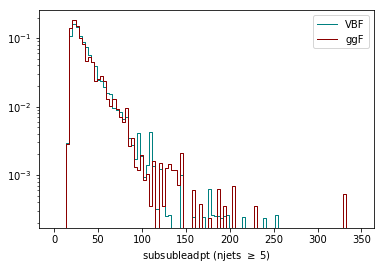

In [81]:
njets_plots('subsubleadpt', 350, nbins=100, saving=False)

In [22]:
## Now we'll graph Delta R_{12} etc

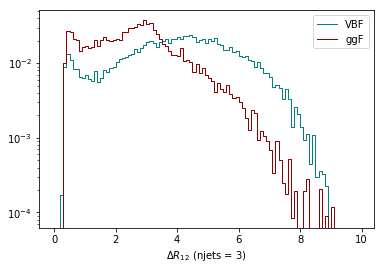

In [24]:
h_dr12, h_dr12_bg, bin_edges = histograms('dr12', (0, 10), vbf_maxpt3, ggf_maxpt3)
plot_histograms(h_dr12, h_dr12_bg, bin_edges, xlabel=r'$\Delta R_{12}$ (njets = 3)', savefig='../imgs/jan18_dr12.pdf')

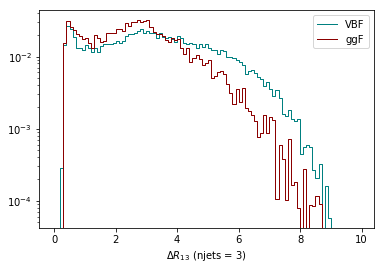

In [25]:
h_dr13, h_dr13_bg, bin_edges = histograms('dr13', (0, 10), vbf_maxpt3, ggf_maxpt3)
plot_histograms(h_dr13, h_dr13_bg, bin_edges, xlabel=r'$\Delta R_{13}$ (njets = 3)', savefig='../imgs/jan18_dr13.pdf')

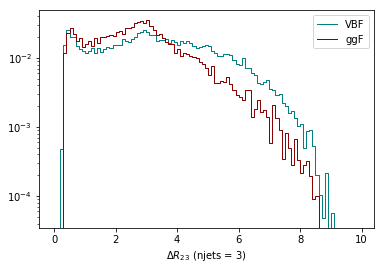

In [26]:
h_dr23, h_dr23_bg, bin_edges = histograms('dr23', (0, 10), vbf_maxpt3, ggf_maxpt3)
plot_histograms(h_dr23, h_dr23_bg, bin_edges, xlabel=r'$\Delta R_{23}$ (njets = 3)', savefig='../imgs/jan18_dr23.pdf')

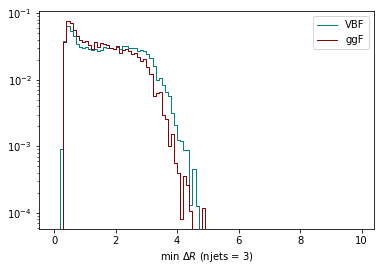

In [27]:
h_mindr, h_mindr_bg, bin_edges = histograms('mindr', (0, 10), vbf_maxpt3, ggf_maxpt3)
plot_histograms(h_mindr, h_mindr_bg, bin_edges, xlabel=r'min $\Delta R$ (njets = 3)', savefig='../imgs/jan18_mindr.pdf')

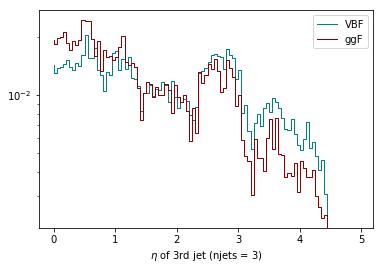

In [28]:
h_eta3, h_eta3_bg, bin_edges = histograms('eta3', (0, 5), vbf_maxpt3, ggf_maxpt3, nbins=100)
plot_histograms(h_eta3, h_eta3_bg, bin_edges, xlabel=r'$\eta$ of 3rd jet (njets = 3)', savefig='../imgs/jan18_eta3.pdf')

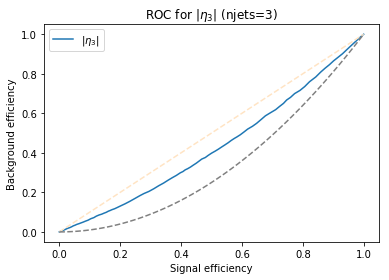

In [83]:
draw_ROC(h_eta3, h_eta3_bg, label=r"$\left| \eta_3 \right|$", title=r"ROC for $|\eta_3|$ (njets=3)",
         savefig='../imgs/jan18_eta3_roc.pdf')

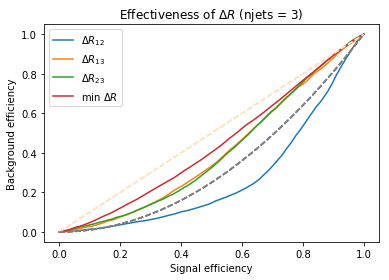

In [31]:
draw_ROC(h_dr12, h_dr12_bg, label=r'$\Delta R_{12}$', show=False)
draw_ROC(h_dr13, h_dr13_bg, label=r'$\Delta R_{13}$', show=False)
draw_ROC(h_dr23, h_dr23_bg, label=r'$\Delta R_{23}$', show=False)
draw_ROC(h_mindr, h_mindr_bg, label=r'min $\Delta R$', title=r'Effectiveness of $\Delta R$ (njets = 3)', savefig='../imgs/jan18_DR.pdf')

In [32]:
vbf_maxpt3.keys()

dict_keys(['weight', 'myy', 'mjj', 'deta', 'leadpt', 'subleadpt', 'subsubleadpt', 'higgspt', 'id', 'dphi', 'maxeta', 'mineta', 'njets', 'dr12', 'dr13', 'dr23', 'mindr', 'eta3'])

In [33]:
#print(len(vbf_maxpt2['njets'])/ len(vbf_maxpt['njets']))
#print(vbf_maxpt2['njets'][:10])

In [36]:
def show_roc_for_var(varname, maxval, nbins=100, saving=False):
    h_reg, h_reg_bg, bin_edges = histograms(varname, (0, maxval), vbf_regular, ggf_regular, nbins=nbins)
    h_maxpt, h_maxpt_bg, bin_edges = histograms(varname, (0, maxval), vbf_maxpt, ggf_maxpt, nbins=nbins)
    h_maxdeta, h_maxdeta_bg, bin_edges = histograms(varname, (0, maxval), vbf_maxdeta, ggf_maxdeta, nbins=nbins)

    draw_ROC(h_reg, h_reg_bg, label='Max Mjj', show=False) # aka regular
    draw_ROC(h_maxpt, h_maxpt_bg, label='Max pT', show=False)
    draw_ROC(h_maxdeta, h_maxdeta_bg, label='Max DEta', title=r'Single variable: %s'%varname,
            savefig=('../imgs/jan24_%s_maxroc.pdf'%varname) if saving else None)
    print('max Mjj:')
    plot_histograms(h_reg, h_reg_bg, bin_edges, xlabel=varname+' (pick jets by max Mjj)',
                    savefig=('../imgs/jan24_%s_maxmjj.pdf'%varname) if saving else None)
    plot_histograms(h_maxpt, h_maxpt_bg, bin_edges, xlabel=varname+' (pick jets by max pT)',
                    savefig=('../imgs/jan24_%s_maxpt.pdf'%varname) if saving else None)
    plot_histograms(h_reg, h_reg_bg, bin_edges, xlabel=varname+' (pick jets by max Deta)',
                    savefig=('../imgs/jan24_%s_maxdeta.pdf'%varname) if saving else None)
#     print('max pt:')
#     plot_histograms(h_maxpt, h_maxpt_bg, bin_edges)
#     print('max deta:')
#     plot_histograms(h_maxdeta, h_maxdeta_bg, bin_edges)

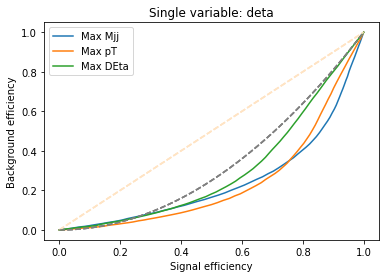

max Mjj:


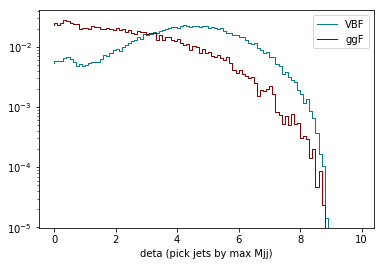

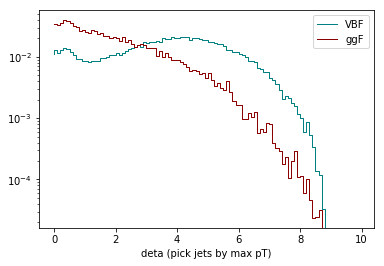

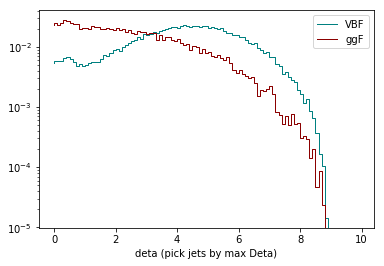

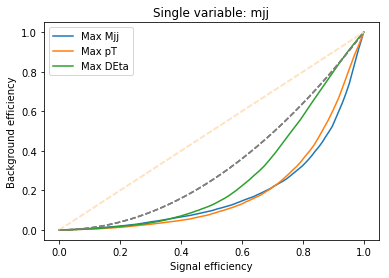

max Mjj:


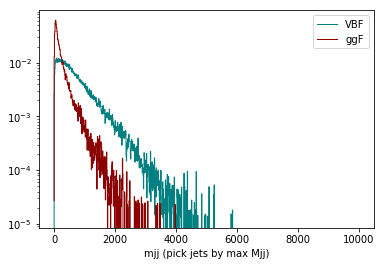

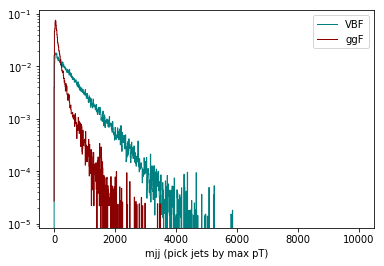

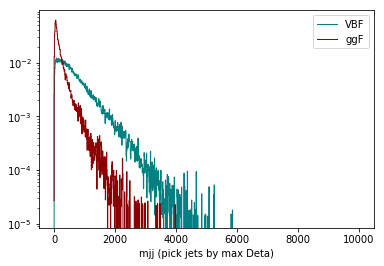

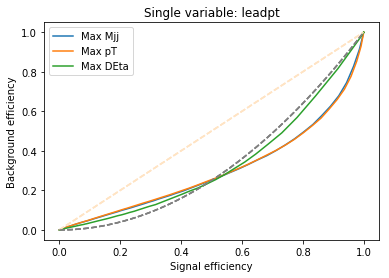

max Mjj:


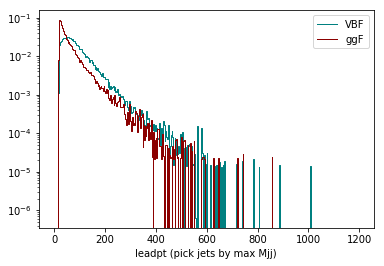

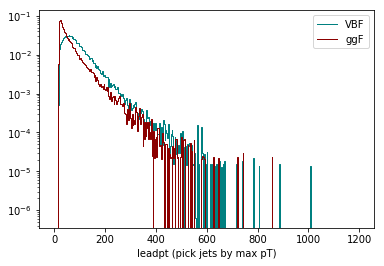

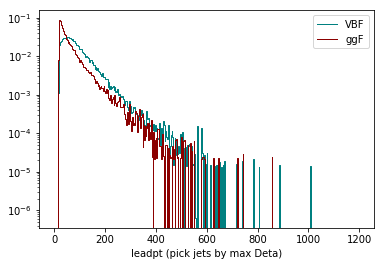

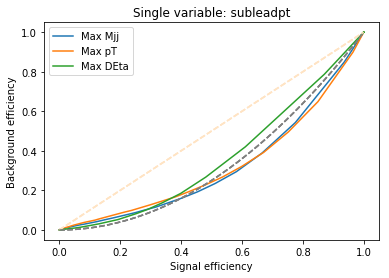

max Mjj:


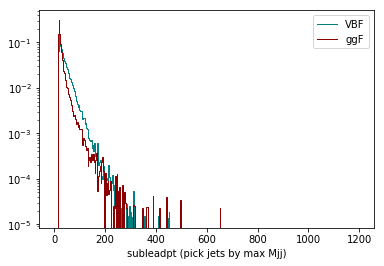

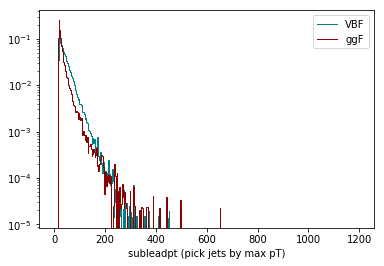

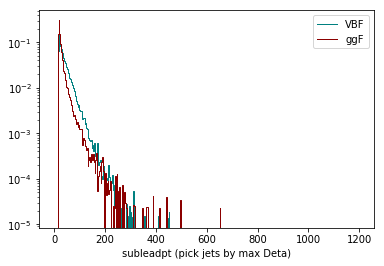

In [37]:
show_roc_for_var('deta',10)
show_roc_for_var('mjj', 10000, nbins=1000)
show_roc_for_var('leadpt', 1200, nbins=400)
show_roc_for_var('subleadpt', 1200, nbins=400)

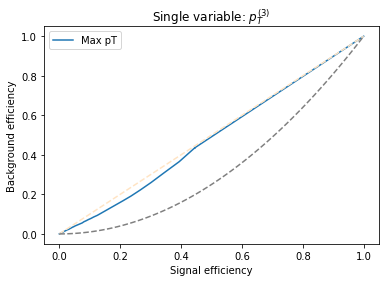

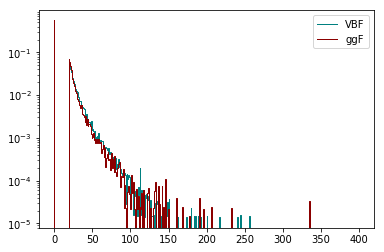

In [41]:
h, h_bg, bin_edges = histograms('subsubleadpt', (0,400), vbf_maxpt, ggf_maxpt, nbins=400)

draw_ROC(h, h_bg, title=r"Single variable: $p_T^{(3)}$", label="Max pT", savefig='../imgs/jan24_pt3_roc.pdf')
plot_histograms(h, h_bg, bin_edges, savefig='../imgs/jan24_pt3.pdf')

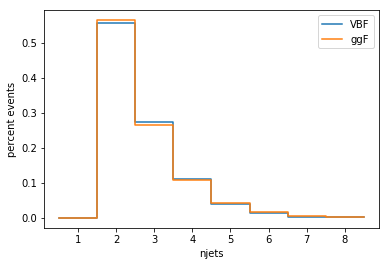

The njets number shown in this graph does not count the "tight photons".


In [43]:
# Graph of njets

vbf_njets, bin_edges = np.histogram(vbf_regular['njets'], bins=np.arange(0,10))
plt.step(.5+bin_edges[:-1], vbf_njets / sum(vbf_njets), label='VBF')
ggf_njets, bin_edges = np.histogram(ggf_regular['njets'], bins=np.arange(0,10))
plt.step(.5+bin_edges[:-1], ggf_njets / sum(ggf_njets), label='ggF')
plt.xlabel('njets')
plt.ylabel('percent events')
plt.legend()
#plt.savefig('../imgs/jan17_njets.pdf')
plt.show()
print('The njets number shown in this graph does not count the "tight photons".')

In [124]:
vbf_njets / np.sum(vbf_njets)

array([ 0.        ,  0.        ,  0.55521553,  0.27417429,  0.11203583,
        0.04000746,  0.01287554,  0.0039373 ,  0.00175406])

In [ ]:
# Comparing lab / Higgs frames

In [116]:
def frame_plots(varname, maxval, nbins=100, saving=False):
    print('Plots for: ' + varname)

    h_reg, h_reg_bg, bin_edges = histograms(varname, (0,maxval), vbf_regular, ggf_regular, nbins=nbins)
    h_higgs, h_higgs_bg, bin_edges = histograms(varname, (0, maxval), vbf_higgs, ggf_higgs, nbins=nbins)

    draw_ROC(h_reg, h_reg_bg, label='Lab frame', show=False)
    draw_ROC(h_higgs, h_higgs_bg, label='Higgs frame', title='ROC for %s'%varname,
             savefig=('../imgs/jan24_%s_frameroc.pdf'%varname) if saving else None)

    plot_histograms(h_reg, h_reg_bg, bin_edges, xlabel=varname+' (Lab frame)',
                    savefig=('../imgs/jan24_%s_lab.pdf'%varname) if saving else None)
    plot_histograms(h_higgs, h_higgs_bg, bin_edges, xlabel=varname+' (Higgs frame)',
                    savefig=('../imgs/jan24_%s_higgs.pdf'%varname) if saving else None)

Plots for: deta


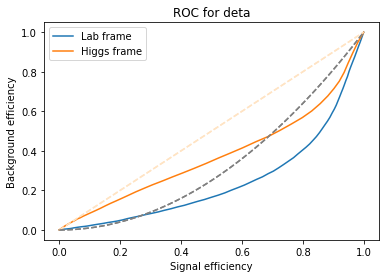

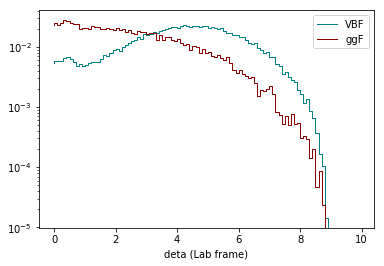

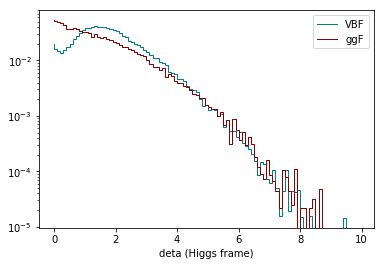

In [98]:
frame_plots('deta',10, saving=False)

Plots for: leadpt


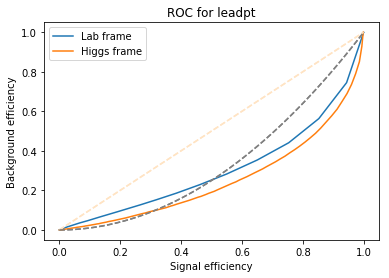

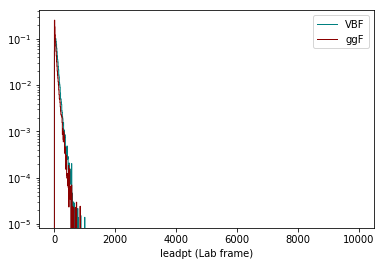

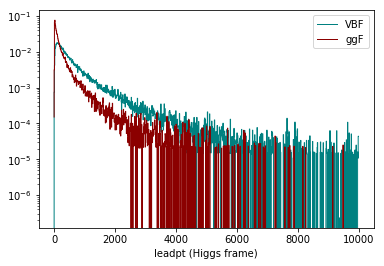

In [122]:
frame_plots('leadpt',10000, nbins=1000, saving=False)

Plots for: subleadpt


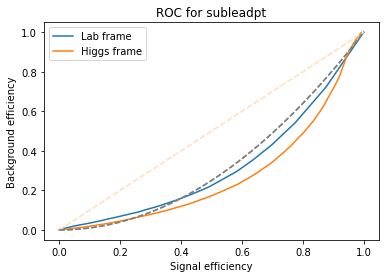

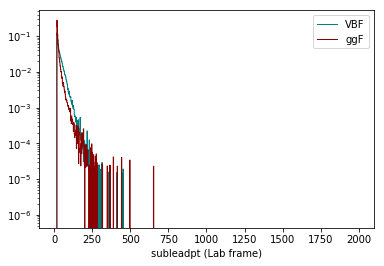

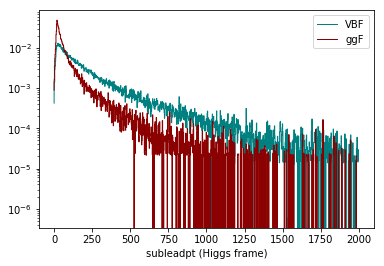

In [120]:
frame_plots('subleadpt',2000, nbins=1000, saving=False)

## Appendix

In [ ]:
h_regular, h_regular_bg, bin_edges = histograms('mjj', (0,1000), vbf_regular, ggf_regular, nbins=100)
h_hacky, h_hacky_bg, bin_edges = histograms('mjj', (0,1000), vbf_hacky, ggf_hacky, nbins=100)
h_selective, h_selective_bg, bin_edges = histograms('mjj', (0,1000), vbf_selective, ggf_selective, nbins=100)
draw_ROC(h_regular, h_regular_bg, title=r'$M_{jj}$', fmt='k', show=False)
draw_ROC(h_hacky, h_hacky_bg, title=r'$M_{jj}$', fmt='b', show=False)
draw_ROC(h_selective, h_selective_bg, title=r'$M_{jj}$', fmt='g')

print('hacky')
plot_histograms(h_hacky, h_hacky_bg, bin_edges)
print('selective')
plot_histograms(h_selective, h_selective_bg, bin_edges)
print('regular')
plot_histograms(h_regular, h_regular_bg, bin_edges)